In [1]:
# Konfiguracja kluczy API (opcjonalne)
# Projekt działa lokalnie bez kluczy (CLIP). 
# Jeśli masz klucze, ustaw je jako zmienne środowiskowe.

import os

# Przykładowe ustawienia (odkomentuj i uzupełnij):
# os.environ["OPENAI_API_KEY"] = "sk-..."           # Płatne
# os.environ["GOOGLE_API_KEY"] = "..."              # Darmowe (limit miesięczny)
# os.environ["HUGGINGFACEHUB_API_TOKEN"] = "hf_..." # Darmowe

# Podgląd ustawień
print("=" * 60)
print("STATUS KLUCZY API")
print("=" * 60)

keys = {
    "OPENAI_API_KEY": ("Płatne", "OpenAI Vision"),
    "GOOGLE_API_KEY": ("Darmowe", "Google Vision"),
    "HUGGINGFACEHUB_API_TOKEN": ("Darmowe", "Hugging Face")
}

any_key = False
for key, (cost, desc) in keys.items():
    value = os.getenv(key)
    if value:
        print(f"✓ {key}: ustawiony ({cost})")
        any_key = True
    else:
        print(f"✗ {key}: brak ({cost})")

print("-" * 60)
if any_key:
    print("Metoda: API (zewnętrzne)")
else:
    print("Metoda: CLIP (offline)")
    print("→ Działa bez kluczy API")
print("=" * 60)

STATUS KLUCZY API
✗ OPENAI_API_KEY: brak (Płatne)
✗ GOOGLE_API_KEY: brak (Darmowe)
✗ HUGGINGFACEHUB_API_TOKEN: brak (Darmowe)
------------------------------------------------------------
Metoda: CLIP (offline)
→ Działa bez kluczy API


In [2]:
# Instalacja pakietów (uruchom raz)
%pip install -q sentence-transformers transformers pillow sqlalchemy torch numpy pandas requests

Note: you may need to restart the kernel to use updated packages.


# RAG do wyszukiwania części metalowych

System rozpoznaje części na obrazach i zapisuje wyniki do SQLite. Może używać zewnętrznych API, ale działa też w pełni offline.

## API (opcjonalnie)
- OpenAI Vision (płatne)
- Google Vision (darmowe limity)
- Hugging Face (captioning)

## Baza danych
- SQLite: metal_parts.db
- Tabele: metal_parts, search_logs
- Pola: part_id, description, material, category, dimensions, tags, image_path, embeddings, created_at

## Jak używać
1. (Opcjonalnie) ustaw klucz do jednego z API.
2. Uruchom komórki 1–7 (inicjalizacja).
3. Uruchom komórkę 17, aby przetworzyć obrazy z obrazy/metal/.
4. Wyniki trafią do bazy.

## Przykład rekordu
{
  "part_id": "BEA-M1",
  "description": "Bearing",
  "material": "Stal chromowana",
  "category": "bearings",
  "dimensions": {"source": "openai_vision_api", "raw_info": "..."},
  "tags": ["metal", "part", "bearings", "api_recognized"],
  "image_path": "obrazy/metal/m1.jpg",
  "created_at": "2025-12-29T..."
}

## 1. Inicjalizacja i Konfiguracja

In [3]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["USE_TF"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import torch
import numpy as np
from pathlib import Path
from typing import List, Optional, Dict
from dataclasses import dataclass
from datetime import datetime

from sqlalchemy import create_engine, Column, Integer, String, Float, JSON, ForeignKey
from sqlalchemy.orm import declarative_base, sessionmaker, Session, relationship
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
import requests

# config - ZAKTUALIZOWANE MODELE (darmowe, lepsze)
EMBEDDING_MODEL = "sentence-transformers/clip-ViT-L-14"  # Większy CLIP (428M vs 151M)
LLM_MODEL = "microsoft/Phi-3-mini-4k-instruct"  # Phi-3 3.8B (vs TinyLlama 1.1B)
DATABASE_URL = "sqlite:///metal_parts.db"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"✓ Urządzenie: {DEVICE}")
print(f"✓ Model embeddingów: {EMBEDDING_MODEL}")
print(f"✓ Model LLM: {LLM_MODEL}")
print(f"✓ Baza danych: {DATABASE_URL}")

# baza danych
Base = declarative_base()

engine = create_engine(DATABASE_URL, echo=False)
SessionLocal = sessionmaker(bind=engine)

✓ Urządzenie: cpu
✓ Model embeddingów: sentence-transformers/clip-ViT-L-14
✓ Model LLM: microsoft/Phi-3-mini-4k-instruct
✓ Baza danych: sqlite:///metal_parts.db


## 2. Modele Danych

In [4]:
from dataclasses import dataclass
from typing import List, Optional, Dict

@dataclass
class MetalPart:
    """Model części metalowej."""
    part_id: str
    description: str
    material: str
    category: str
    dimensions: Dict
    tags: List[str]
    image_path: Optional[str] = None
    image_embedding: Optional[List[float]] = None
    text_embedding: Optional[List[float]] = None


class PartDB(Base):
    """Tabela: metal_parts."""
    __tablename__ = "metal_parts"

    id = Column(Integer, primary_key=True, autoincrement=True)
    part_id = Column(String, unique=True, nullable=False)
    description = Column(String, nullable=False)
    material = Column(String, nullable=True)
    category = Column(String, nullable=True)
    dimensions = Column(JSON, nullable=True)
    tags = Column(JSON, nullable=True)
    image_path = Column(String, nullable=True)
    image_embedding = Column(String, nullable=True)
    text_embedding = Column(String, nullable=True)
    created_at = Column(String, nullable=True)


class SearchLog(Base):
    """Tabela: search_logs."""
    __tablename__ = "search_logs"

    id = Column(Integer, primary_key=True, autoincrement=True)
    query = Column(String, nullable=False)
    query_type = Column(String, nullable=False)
    top_k = Column(Integer, nullable=True)
    results_count = Column(Integer, nullable=True)
    timestamp = Column(String, nullable=True)

def init_database():
    """Tworzy tabele."""
    Base.metadata.create_all(engine)
    print("✓ Baza danych zainicjalizowana")

init_database()

✓ Baza danych zainicjalizowana


## 3. Embeddingi i Ekstrakcja Cech

In [5]:
# Embeddingi
print("Ładowanie modelu embeddingów...")
embedding_model = SentenceTransformer(EMBEDDING_MODEL, device=DEVICE)
print(f"✓ Model embeddingów: {EMBEDDING_MODEL}")

def get_text_embedding(text: str) -> List[float]:
    """Tekst → embedding."""
    embedding = embedding_model.encode(text, normalize_embeddings=True)
    return embedding.tolist()


def get_image_embedding(image_path: str) -> List[float]:
    """Obraz → embedding."""
    from PIL import Image
    try:
        img = Image.open(image_path).convert('RGB')
        img_embedding = embedding_model.encode(img, normalize_embeddings=True)
        return img_embedding.tolist()
    except Exception as e:
        print(f"✗ Błąd wczytywania obrazu {image_path}: {e}")
        return None


def build_part_text(part: MetalPart) -> str:
    """Krótki opis części do embeddingu."""
    dims_str = ", ".join([f"{k}: {v}" for k, v in (part.dimensions or {}).items()])
    tags_str = ", ".join(part.tags)

    text = f"""
    Część metalowa: {part.description}
    ID: {part.part_id}
    Kategoria: {part.category}
    Materiał: {part.material}
    Wymiary: {dims_str}
    Tagi: {tags_str}
    """
    return text


# Szybki test
test_text = "Śruba sześciokątna M8 ze stali nierdzewnej"
test_emb = get_text_embedding(test_text)
print(f"\n✓ Test embeddingu tekstowego:")
print(f"  Tekst: {test_text}")
print(f"  Długość embeddingu: {len(test_emb)}D")
print(f"  Pierwsze 5 wartości: {test_emb[:5]}")

Ładowanie modelu embeddingów...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✓ Model embeddingów: sentence-transformers/clip-ViT-L-14

✓ Test embeddingu tekstowego:
  Tekst: Śruba sześciokątna M8 ze stali nierdzewnej
  Długość embeddingu: 768D
  Pierwsze 5 wartości: [0.002034200355410576, 0.01766085810959339, -0.024842247366905212, 0.0220972690731287, -0.018095970153808594]


## 4. Funkcje do Indeksowania Części

In [6]:
def add_part_to_db(db: Session, part: MetalPart) -> bool:
    """Dodaje część do bazy."""
    try:
        text_desc = build_part_text(part)
        text_emb = get_text_embedding(text_desc)

        image_emb = None
        if part.image_path and Path(part.image_path).exists():
            image_emb = get_image_embedding(part.image_path)

        text_emb_str = ";".join(str(x) for x in text_emb) if text_emb else None
        image_emb_str = ";".join(str(x) for x in image_emb) if image_emb else None

        db_part = PartDB(
            part_id=part.part_id,
            description=part.description,
            material=part.material,
            category=part.category,
            dimensions=part.dimensions,
            tags=part.tags,
            image_path=part.image_path,
            text_embedding=text_emb_str,
            image_embedding=image_emb_str,
            created_at=datetime.now().isoformat()
        )
        db.add(db_part)
        db.commit()
        return True
    except Exception as e:
        print(f"✗ Błąd dodawania części: {e}")
        return False


def load_parts_from_db(db: Session) -> List[PartDB]:
    """Zwraca wszystkie części."""
    return db.query(PartDB).all()


def parse_embedding_from_db(emb_str: str) -> List[float]:
    """Konwersja string → lista float."""
    if not emb_str:
        return None
    return [float(x) for x in emb_str.split(";")]


def cosine_similarity(a: List[float], b: List[float]) -> float:
    """Podobieństwo kosinusowe."""
    a = np.array(a)
    b = np.array(b)
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)

print("✓ Funkcje indeksowania załadowane")

✓ Funkcje indeksowania załadowane


## 5. Retriever - Wyszukiwanie Podobnych Części

In [7]:
def search_parts_by_text(db: Session, query: str, top_k: int = 5, category_filter: Optional[str] = None) -> List[tuple]:
    """Wyszukiwanie po tekście."""
    query_emb = get_text_embedding(query)
    all_parts = load_parts_from_db(db)

    results = []
    for part in all_parts:
        if category_filter and part.category != category_filter:
            continue

        part_emb = parse_embedding_from_db(part.image_embedding)
        if not part_emb:
            continue

        score = cosine_similarity(query_emb, part_emb)
        results.append((part, score))

    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]


def search_parts_by_image(db: Session, image_path: str, top_k: int = 5, category_filter: Optional[str] = None) -> List[tuple]:
    """Wyszukiwanie po obrazie."""
    query_emb = get_image_embedding(image_path)
    if not query_emb:
        return []

    all_parts = load_parts_from_db(db)

    results = []
    for part in all_parts:
        if category_filter and part.category != category_filter:
            continue

        part_emb = parse_embedding_from_db(part.image_embedding)
        if not part_emb:
            continue

        score = cosine_similarity(query_emb, part_emb)
        results.append((part, score))

    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]


def search_parts_hybrid(db: Session, text_query: str, image_path: Optional[str] = None,
                       top_k: int = 5, category_filter: Optional[str] = None) -> List[tuple]:
    """Hybryda: tekst + obraz."""
    text_results = search_parts_by_text(db, text_query, top_k=top_k*2, category_filter=category_filter)

    if image_path and Path(image_path).exists():
        image_results = search_parts_by_image(db, image_path, top_k=top_k*2, category_filter=category_filter)

        combined = {}
        for part, score in text_results:
            combined[part.id] = {"part": part, "score": score * 0.7}

        for part, score in image_results:
            if part.id in combined:
                combined[part.id]["score"] += score * 0.3
            else:
                combined[part.id] = {"part": part, "score": score * 0.3}

        results = [(v["part"], v["score"]) for v in combined.values()]
    else:
        results = text_results

    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]

print("✓ Retriever załadowany")

✓ Retriever załadowany


## 6. LLM - Generacja Raportu

In [8]:
# Model LLM
print("Ładowanie modelu LLM...")
try:
    tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL)
    llm_model = AutoModelForCausalLM.from_pretrained(LLM_MODEL, low_cpu_mem_usage=True)
    llm_model.to(DEVICE)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    print(f"✓ LLM: {LLM_MODEL}")
except Exception as e:
    print(f"✗ Błąd ładowania LLM: {e}")
    llm_model = None
    tokenizer = None


def generate_report(results: List[tuple], query: str) -> str:
    """Raport na podstawie wyników."""
    if not llm_model or not tokenizer:
        return generate_simple_report(results, query)

    context = "\n\n".join([
        f"Część {i+1}:\n"
        f"  ID: {part.part_id}\n"
        f"  Opis: {part.description}\n"
        f"  Materiał: {part.material}\n"
        f"  Kategoria: {part.category}\n"
        f"  Wymiary: {part.dimensions}\n"
        f"  Tagi: {', '.join(part.tags or [])}\n"
        f"  Dopasowanie: {score*100:.1f}%"
        for i, (part, score) in enumerate(results)
    ])

    prompt = f"""
    Zapytanie użytkownika: "{query}"

    Wyniki:
    {context}

    Proszę o krótki, konkretny raport.
    """

    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(DEVICE)

    with torch.no_grad():
        outputs = llm_model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.split("Wyniki:")[-1].strip() if "Wyniki:" in response else response


def generate_simple_report(results: List[tuple], query: str) -> str:
    """Prosty tekstowy raport."""
    report = f"RAPORT WYSZUKIWANIA\n"
    report += f"Zapytanie: {query}\n"
    report += f"Znaleziono: {len(results)} części\n"
    report += "\n" + "="*60 + "\n\n"

    for i, (part, score) in enumerate(results, 1):
        report += f"#{i} (Dopasowanie: {score*100:.1f}%)\n"
        report += f"  ID: {part.part_id}\n"
        report += f"  Opis: {part.description}\n"
        report += f"  Materiał: {part.material}\n"
        report += f"  Kategoria: {part.category}\n"
        if part.dimensions:
            report += f"  Wymiary: {part.dimensions}\n"
        if part.tags:
            report += f"  Tagi: {', '.join(part.tags)}\n"
        report += "\n"

    return report

print("✓ Funkcje raportu załadowane")

Ładowanie modelu LLM...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ LLM: microsoft/Phi-3-mini-4k-instruct
✓ Funkcje raportu załadowane


## 7. Główna Funkcja RAG

In [9]:
def rag_search_metal_parts(query: str, query_type: str = "text", image_path: Optional[str] = None,
                          category_filter: Optional[str] = None, top_k: int = 5) -> Dict:
    """Główna funkcja RAG."""
    with SessionLocal() as db:
        if query_type == "text":
            results = search_parts_by_text(db, query, top_k=top_k, category_filter=category_filter)
        elif query_type == "image":
            if not image_path:
                return {"error": "Brak ścieżki do obrazu dla query_type='image'."}
            results = search_parts_by_image(db, image_path, top_k=top_k, category_filter=category_filter)
        elif query_type == "hybrid":
            if not image_path:
                return {"error": "Brak ścieżki do obrazu dla query_type='hybrid'."}
            results = search_parts_hybrid(db, query, image_path=image_path, top_k=top_k, category_filter=category_filter)
        else:
            return {"error": f"Nieznany typ wyszukiwania: {query_type}"}

        results_dicts = [
            ({
                "id": part.id,
                "part_id": part.part_id,
                "description": part.description,
                "material": part.material,
                "category": part.category,
                "dimensions": part.dimensions,
                "tags": part.tags,
                "image_path": part.image_path,
                "created_at": part.created_at,
                "similarity_score": float(score),
            }, score)
            for part, score in results
        ]

        report = generate_simple_report(results, query)

        log = SearchLog(
            query=query,
            query_type=query_type,
            top_k=top_k,
            results_count=len(results),
            timestamp=datetime.now().isoformat(),
        )
        db.add(log)
        db.commit()

        return {
            "query": query,
            "query_type": query_type,
            "results": results_dicts,
            "report": report,
            "timestamp": datetime.now().isoformat(),
        }


def display_search_results(results_data: Dict) -> None:
    """Czytelny wydruk wyników."""
    print(f"\n{'='*90}")
    print("WYNIKI WYSZUKIWANIA")
    print(f"{'='*90}")
    print(f"Query: {results_data.get('query', 'N/A')}")
    print(f"Typ: {results_data.get('query_type', 'N/A')}")
    print(f"Timestamp: {results_data.get('timestamp', 'N/A')}")
    print(f"Znaleziono: {len(results_data.get('results', []))} części\n")

    rows = results_data.get('results', [])
    if not rows:
        print("⚠ Brak wyników")
        return

    print(f"{'#':<3} | {'ID':<15} | {'Opis':<35} | {'Materiał':<20} | {'Kategoria':<15} | {'Score':<8}")
    print(f"{'-'*3}-+-{'-'*15}-+-{'-'*35}-+-{'-'*20}-+-{'-'*15}-+-{'-'*8}")

    for i, (part_dict, score) in enumerate(rows, 1):
        part_id = (part_dict.get('part_id') or 'N/A')[:15]
        description = (part_dict.get('description') or 'N/A')[:35]
        material = (part_dict.get('material') or 'N/A')[:20]
        category = (part_dict.get('category') or 'N/A')[:15]
        score_val = f"{score:.4f}"
        print(f"{i:<3} | {part_id:<15} | {description:<35} | {material:<20} | {category:<15} | {score_val:<8}")

    best_match, best_score = rows[0]
    print(f"\n{'='*90}")
    print("NAJLEPSZE DOPASOWANIE:")
    print(f"{'='*90}")
    print(f"ID bazy:         {best_match.get('id', 'N/A')}")
    print(f"Part ID:         {best_match.get('part_id', 'N/A')}")
    print(f"Opis:            {best_match.get('description', 'N/A')}")
    print(f"Materiał:        {best_match.get('material', 'N/A')}")
    print(f"Kategoria:       {best_match.get('category', 'N/A')}")
    print(f"Wymiary:         {best_match.get('dimensions', {})}")
    tags_val = best_match.get('tags') or []
    print(f"Tagi:            {', '.join(tags_val) if tags_val else ''}")
    print(f"Ścieżka obrazu:  {best_match.get('image_path', 'N/A')}")
    print(f"Utworzono:       {best_match.get('created_at', 'N/A')}")
    print(f"Similarity:      {best_score:.4f}")
    print(f"{'='*90}\n")

## 8. Przykładowe Dane i Test

In [10]:
# Klasyfikacja obrazów części metalowych
import os
import requests
import json
import base64
from pathlib import Path
from PIL import Image

# Konfiguracja API
HF_API_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

# Podpisy obrazów (Hugging Face)
HF_CAPTION_ENDPOINT = "https://api-inference.huggingface.co/models/Salesforce/blip2-opt-2.7b"


def analyze_image_with_openai(image_path: str) -> Optional[Dict]:
    """Analiza przez OpenAI Vision."""
    if not OPENAI_API_KEY:
        return None
    
    try:
        with open(image_path, "rb") as f:
            image_data = base64.b64encode(f.read()).decode('utf-8')
        
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OPENAI_API_KEY}"
        }
        
        payload = {
            "model": "gpt-4o-mini",
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": """Analyze this metal part image and provide:
1. Part name (e.g., "Bearing", "Bolt", "Screw", "Nut", "Washer")
2. Material (e.g., "Stal chromowana", "Aluminium", "Stal nierdzewna")
3. Category (e.g., "bearings", "fasteners", "bolts", "nuts")
4. Estimated dimensions if visible
5. Any visible markings or specifications

Respond in JSON format:
{
    "part_name": "string",
    "material": "string", 
    "category": "string",
    "dimensions": "string or null",
    "description": "brief description"
}"""
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{image_data}"
                            }
                        }
                    ]
                }
            ],
            "max_tokens": 500
        }
        
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=payload,
            timeout=30
        )
        response.raise_for_status()
        
        result = response.json()
        content = result['choices'][0]['message']['content']
        
        try:
            if "```json" in content:
                json_str = content.split("```json")[1].split("```")[0].strip()
            elif "```" in content:
                json_str = content.split("```")[1].split("```")[0].strip()
            else:
                json_str = content.strip()
            
            data = json.loads(json_str)
            return data
        except:
            return {"description": content}
            
    except Exception as e:
        print(f"⚠ Błąd OpenAI Vision API: {e}")
        return None


def analyze_image_with_google(image_path: str) -> Optional[Dict]:
    """Analiza przez Google Vision."""
    if not GOOGLE_API_KEY:
        return None
    
    try:
        from google.cloud import vision
        import io
        
        client = vision.ImageAnnotatorClient()
        
        with io.open(image_path, 'rb') as image_file:
            content = image_file.read()
        
        image = vision.Image(content=content)
        
        response = client.label_detection(image=image)
        labels = response.label_annotations
        
        text_response = client.text_detection(image=image)
        texts = text_response.text_annotations
        
        result = {
            "labels": [label.description for label in labels[:5]],
            "text": texts[0].description if texts else None,
            "confidence": labels[0].score if labels else 0
        }
        
        return result
        
    except Exception as e:
        print(f"⚠ Błąd Google Vision API: {e}")
        return None


def caption_image_online(image_path: str) -> Optional[str]:
    """Podpis z Hugging Face."""
    if not HF_API_TOKEN:
        return None
    try:
        with open(image_path, "rb") as f:
            img_bytes = f.read()
        headers = {"Authorization": f"Bearer {HF_API_TOKEN}"}
        resp = requests.post(HF_CAPTION_ENDPOINT, headers=headers, data=img_bytes, timeout=25)
        resp.raise_for_status()
        out = resp.json()
        if isinstance(out, list) and out and isinstance(out[0], dict) and "generated_text" in out[0]:
            return out[0]["generated_text"]
    except Exception as e:
        print(f"⚠ Nie udało się pobrać podpisu z HF: {e}")
    return None


def classify_metal_part_from_image(image_path: str) -> Optional[MetalPart]:
    """Klasyfikacja z obrazu (OpenAI > Google > CLIP).""" ### clip?
    try:
        if not Path(image_path).exists():
            print(f"✗ Obraz nie znaleziony: {image_path}")
            return None
        
        img = Image.open(image_path).convert('RGB')
        
        print(f"   🔍 Próba rozpoznania przez OpenAI Vision API...")
        api_result = analyze_image_with_openai(image_path)
        
        if api_result and 'part_name' in api_result:
            print(f"   ✓ OpenAI: {api_result.get('part_name')}")
            
            part_name = api_result.get('part_name', 'Unknown Part')
            material = api_result.get('material', 'Nieznany')
            category = api_result.get('category', 'fasteners')
            description_text = api_result.get('description', part_name)
            dimensions_str = api_result.get('dimensions', '')
            
            img_embedding = embedding_model.encode(img, normalize_embeddings=True)
            part_id = Path(image_path).stem.upper()
            tags = ["metal", "part", category, "api_recognized", image_path]
            if dimensions_str:
                tags.append(f"dim:{dimensions_str}")
            
            dimensions = {
                "source": "openai_vision_api",
                "raw_info": dimensions_str or "not_specified"
            }
            
            part = MetalPart(
                part_id=f"{category.upper()[:3]}-{part_id}",
                description=part_name,
                material=material,
                category=category,
                dimensions=dimensions,
                tags=tags,
                image_path=image_path,
                image_embedding=img_embedding.tolist()
            )
            
            print(f"   ↳ Nazwa: {part_name}")
            print(f"   ↳ Kategoria: {category}")
            print(f"   ↳ Materiał: {material}")
            
            return part
        
        print(f"   🔍 Próba rozpoznania przez Google Vision API...")
        google_result = analyze_image_with_google(image_path)
        
        if google_result and google_result.get('labels'):
            print(f"   ✓ Google Vision: {', '.join(google_result['labels'][:3])}")
        
        print(f"   🔍 Fallback: CLIP embedding...")
        
        caption = caption_image_online(image_path)
        if caption:
            print(f"   ↳ Caption: {caption}")
        
        img_embedding = embedding_model.encode(img, normalize_embeddings=True)
        
        categories = [
            "fasteners", "bearings", "springs", "shafts", "gears",
            "nuts", "bolts", "washers", "plates", "brackets", "pipes",
            "screws", "rivets", "hinges", "clamps"
        ]
        materials = [
            "Stal nierdzewna", "Stal zwykła", "Stal chromowana", "Stal hartowana",
            "Aluminium", "Miedź", "Brąz", "Tytan", "Żeliwo", "Nieznany"
        ]
        
        from scipy.spatial.distance import cosine
        category_embeddings = [embedding_model.encode(f"A {cat} part", normalize_embeddings=True) for cat in categories]
        material_embeddings = [embedding_model.encode(f"Made of {mat}", normalize_embeddings=True) for mat in materials]
        
        category_scores = [1 - cosine(img_embedding, cat_emb) for cat_emb in category_embeddings]
        material_scores = [1 - cosine(img_embedding, mat_emb) for mat_emb in material_embeddings]
        
        best_category = categories[int(np.argmax(category_scores))]
        best_material = materials[int(np.argmax(material_scores))]
        
        category_names = {
            "fasteners": "Fastener", "bearings": "Bearing", "springs": "Spring",
            "shafts": "Shaft", "gears": "Gear", "nuts": "Nut", "bolts": "Bolt",
            "washers": "Washer", "plates": "Plate", "brackets": "Bracket",
            "pipes": "Pipe", "screws": "Screw", "rivets": "Rivet",
            "hinges": "Hinge", "clamps": "Clamp"
        }
        part_name = category_names.get(best_category, best_category.capitalize())
        
        print(f"   ↳ CLIP: {part_name} ({best_category})")
        
        part_id = Path(image_path).stem.upper()
        tags = ["metal", "part", best_category, "clip_classified", image_path]
        
        part = MetalPart(
            part_id=f"{best_category.upper()[:3]}-{part_id}",
            description=part_name,
            material=best_material,
            category=best_category,
            dimensions={"source": "clip_embedding"},
            tags=tags,
            image_path=image_path,
            image_embedding=img_embedding.tolist()
        )
        return part
        
    except Exception as e:
        print(f"✗ Błąd klasyfikacji obrazu {image_path}: {e}")
        import traceback
        traceback.print_exc()
        return None


def classify_parts_from_folder(folder_path: str = "obrazy/metal/") -> List[MetalPart]:
    """Klasyfikacja obrazów z folderu."""
    parts = []
    image_extensions = ['.jpg', '.jpeg', '.png', '.webp', '.bmp']
    
    folder = Path(folder_path)
    if not folder.exists():
        print(f"⚠ Folder nie istnieje: {folder_path}")
        return parts
    
    image_files = []
    for ext in image_extensions:
        image_files.extend(folder.glob(f"*{ext}"))
        image_files.extend(folder.glob(f"*{ext.upper()}"))
    
    if not image_files:
        print(f"⚠ Brak obrazów w folderze: {folder_path}")
        return parts
    
    print(f"\n🔍 Klasyfikowanie {len(image_files)} obrazów z folderu {folder_path}...")
    print(f"📡 API dostępne:")
    print(f"   - OpenAI Vision: {'✓' if OPENAI_API_KEY else '✗'}")
    print(f"   - Google Vision: {'✓' if GOOGLE_API_KEY else '✗'}")
    print(f"   - Hugging Face: {'✓' if HF_API_TOKEN else '✗'}")
    print()
    
    for image_file in sorted(image_files):
        print(f"\n{'='*70}")
        print(f"📷 {image_file.name}")
        print(f"{'='*70}")
        part = classify_metal_part_from_image(str(image_file))
        if part:
            parts.append(part)
            print(f"\n✓ ZAPISANO:")
            print(f"   ID: {part.part_id}")
            print(f"   Nazwa: {part.description}")
            print(f"   Kategoria: {part.category}")
            print(f"   Materiał: {part.material}")
        else:
            print(f"\n✗ Nie udało się sklasyfikować")
    
    print(f"\n{'='*70}")
    print(f"✓ Zaklasyfikowano {len(parts)} z {len(image_files)} obrazów")
    print(f"{'='*70}")
    return parts


def fetch_parts_from_internet() -> List[MetalPart]:
    """Rozpoznawanie przez API lub offline."""
    print("📷 Rozpoznawanie części metalowych przez API...")
    parts_from_images = classify_parts_from_folder("obrazy/metal/")
    if parts_from_images:
        print(f"\n✓ Rozpoznano {len(parts_from_images)} części")
        return parts_from_images
    print("\n⚠ Nie znaleziono obrazów lub rozpoznawanie nie powiodło się")
    return []


# Rozpoznaj wszystkie obrazy
print("\n" + "="*70)
print("ROZPOZNAWANIE CZĘŚCI METALOWYCH PRZEZ API")
print("="*70)
CURRENT_PARTS = fetch_parts_from_internet()

# Dodaj do bazy
with SessionLocal() as db:
    existing = db.query(PartDB).count()
    if existing == 0:
        print(f"\n{'='*70}")
        print(f"DODAWANIE {len(CURRENT_PARTS)} CZĘŚCI DO BAZY DANYCH")
        print(f"{'='*70}\n")
        for part in CURRENT_PARTS:
            success = add_part_to_db(db, part)
            if success:
                print(f"✓ {part.part_id}: {part.description}")
                print(f"  └─ {part.category} | {part.material} | {part.image_path}")
        print(f"\n{'='*70}")
        print(f"✓ {len(CURRENT_PARTS)} części zapisanych w bazie SQLite")
        print(f"{'='*70}\n")
    else:
        print(f"\n✓ Baza zawiera już {existing} części")
        print(f"   Aby ponownie zaindeksować, uruchom komórkę 1 (wyczyść bazę).\n")


ROZPOZNAWANIE CZĘŚCI METALOWYCH PRZEZ API
📷 Rozpoznawanie części metalowych przez API...

🔍 Klasyfikowanie 34 obrazów z folderu obrazy/metal/...
📡 API dostępne:
   - OpenAI Vision: ✗
   - Google Vision: ✗
   - Hugging Face: ✗


📷 m1.jpg
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Pipe (pipes)

✓ ZAPISANO:
   ID: PIP-M1
   Nazwa: Pipe
   Kategoria: pipes
   Materiał: Tytan

📷 m1.jpg
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Pipe (pipes)

✓ ZAPISANO:
   ID: PIP-M1
   Nazwa: Pipe
   Kategoria: pipes
   Materiał: Tytan

📷 m10.webp
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Fastener (fasteners)

✓ ZAPISANO:
   ID: FAS-M10
   Nazwa: Fastener
   Kategoria: fasteners
   Materiał: Aluminium

📷 m1

## 9. Testy Wyszukiwania RAG

In [11]:
def add_new_metal_part_from_image(image_path: str) -> bool:
    """Dodaj nową część z obrazu"""
    print(f"\n📷 Klasyfikuję nową część z obrazu: {image_path}")
    
    part = classify_metal_part_from_image(image_path)
    if not part:
        print(f"✗ Nie udało się zaklasyfikować obrazu")
        return False
    
    print(f"\nZaklasyfikowana część:")
    print(f"  ID: {part.part_id}")
    print(f"  Opis: {part.description}")
    print(f"  Kategoria: {part.category}")
    print(f"  Materiał: {part.material}")
    print(f"  Tagi: {', '.join(part.tags)}")
    
    with SessionLocal() as db:
        existing = db.query(PartDB).filter_by(image_path=image_path).first()
        if existing:
            print(f"\n⚠ Część z tego obrazu już istnieje w bazie: {existing.part_id}")
            return False
        
        success = add_part_to_db(db, part)
        if success:
            print(f"\n✓ Część dodana do bazy!")
            return True
        else:
            print(f"\n✗ Błąd podczas dodawania do bazy")
            return False


# test dodawania nowej części
print("\n" + "="*70)
print("TEST: Dodanie Nowej Części z Obrazu")
print("="*70)

test_new_image = "obrazy/metal/m1.jpg"
if Path(test_new_image).exists():
    add_new_metal_part_from_image(test_new_image)
else:
    print(f"⚠ Test image {test_new_image} nie znaleziony")


TEST: Dodanie Nowej Części z Obrazu

📷 Klasyfikuję nową część z obrazu: obrazy/metal/m1.jpg
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Pipe (pipes)

Zaklasyfikowana część:
  ID: PIP-M1
  Opis: Pipe
  Kategoria: pipes
  Materiał: Tytan
  Tagi: metal, part, pipes, clip_classified, obrazy/metal/m1.jpg
✗ Błąd dodawania części: (sqlite3.IntegrityError) UNIQUE constraint failed: metal_parts.part_id
[SQL: INSERT INTO metal_parts (part_id, description, material, category, dimensions, tags, image_path, image_embedding, text_embedding, created_at) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)]
[parameters: ('PIP-M1', 'Pipe', 'Tytan', 'pipes', '{"source": "clip_embedding"}', '["metal", "part", "pipes", "clip_classified", "obrazy/metal/m1.jpg"]', 'obrazy/metal/m1.jpg', '0.04338141530752182;0.01019307877868414;0.047701891511678696;0.017829623073339462;-0.016146371141076088;0.016490498557686806;0.0312488824

In [12]:
def test_api_recognition(image_path: str):
    """Test rozpoznawania API"""
    print(f"\n{'='*70}")
    print(f"TEST ROZPOZNAWANIA PRZEZ API")
    print(f"{'='*70}")
    print(f"Obraz: {image_path}\n")
    
    print("📡 Status API:")
    print(f"   OpenAI Vision: {'✓ Dostępne' if OPENAI_API_KEY else '✗ Brak klucza (ustaw OPENAI_API_KEY)'}")
    print(f"   Google Vision: {'✓ Dostępne' if GOOGLE_API_KEY else '✗ Brak klucza (ustaw GOOGLE_API_KEY)'}")
    print(f"   Hugging Face:  {'✓ Dostępne' if HF_API_TOKEN else '✗ Brak klucza (ustaw HUGGINGFACEHUB_API_TOKEN)'}")
    print()
    
    if not Path(image_path).exists():
        print(f"✗ Plik nie istnieje: {image_path}")
        return None
    
    part = classify_metal_part_from_image(image_path)
    
    if part:
        print(f"\n{'='*70}")
        print("✓ WYNIK ROZPOZNAWANIA:")
        print(f"{'='*70}")
        print(f"Part ID:      {part.part_id}")
        print(f"Nazwa:        {part.description}")
        print(f"Kategoria:    {part.category}")
        print(f"Materiał:     {part.material}")
        print(f"Wymiary:      {part.dimensions}")
        print(f"Tagi:         {', '.join(part.tags[:5])}")
        print(f"Ścieżka:      {part.image_path}")
        print(f"{'='*70}\n")
        
        save = input("Zapisać do bazy danych? (t/n): ").lower()
        if save == 't':
            with SessionLocal() as db:
                success = add_part_to_db(db, part)
                if success:
                    print(f"✓ Zapisano do bazy!")
                else:
                    print(f"✗ Błąd zapisu")
        
        return part
    else:
        print("\n✗ Nie udało się rozpoznać obrazu")
        return None


# test na przykładowym obrazie
test_image = "obrazy/metal/m1.jpg"
if Path(test_image).exists():
    print("🔍 Testowanie rozpoznawania API na przykładowym obrazie...")
    test_api_recognition(test_image)
else:
    print(f"⚠ Przykładowy obraz nie znaleziony: {test_image}")
    print("   Podaj ścieżkę do obrazu: test_api_recognition('ścieżka/do/obrazu.jpg')")

🔍 Testowanie rozpoznawania API na przykładowym obrazie...

TEST ROZPOZNAWANIA PRZEZ API
Obraz: obrazy/metal/m1.jpg

📡 Status API:
   OpenAI Vision: ✗ Brak klucza (ustaw OPENAI_API_KEY)
   Google Vision: ✗ Brak klucza (ustaw GOOGLE_API_KEY)
   Hugging Face:  ✗ Brak klucza (ustaw HUGGINGFACEHUB_API_TOKEN)

   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Pipe (pipes)

✓ WYNIK ROZPOZNAWANIA:
Part ID:      PIP-M1
Nazwa:        Pipe
Kategoria:    pipes
Materiał:     Tytan
Wymiary:      {'source': 'clip_embedding'}
Tagi:         metal, part, pipes, clip_classified, obrazy/metal/m1.jpg
Ścieżka:      obrazy/metal/m1.jpg

✗ Błąd dodawania części: (sqlite3.IntegrityError) UNIQUE constraint failed: metal_parts.part_id
[SQL: INSERT INTO metal_parts (part_id, description, material, category, dimensions, tags, image_path, image_embedding, text_embedding, created_at) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)]
[

In [13]:
# reindeksowanie z aktualnym modelem
print("Ponowne indeksowanie części...")
with SessionLocal() as db:
    db.query(PartDB).delete()
    db.query(SearchLog).delete()
    db.commit()

    for part in CURRENT_PARTS:
        success = add_part_to_db(db, part)
        if success:
            print(f"  ✓ Re-indexed: {part.part_id}")
    print("✓ Wszystkie części ponownie zaindeksowane\n")

# test 1: wyszukiwanie tekstowe
print("\n" + "="*70)
print("TEST 1: Wyszukiwanie tekstowe")
print("="*70)

result1 = rag_search_metal_parts(
    query="Szukam śruby metalowej do połączenia części",
    query_type="text",
    top_k=3
)

display_search_results(result1)

Ponowne indeksowanie części...
  ✓ Re-indexed: PIP-M1
✗ Błąd dodawania części: (sqlite3.IntegrityError) UNIQUE constraint failed: metal_parts.part_id
[SQL: INSERT INTO metal_parts (part_id, description, material, category, dimensions, tags, image_path, image_embedding, text_embedding, created_at) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)]
[parameters: ('PIP-M1', 'Pipe', 'Tytan', 'pipes', '{"source": "clip_embedding"}', '["metal", "part", "pipes", "clip_classified", "obrazy\\\\metal\\\\m1.jpg"]', 'obrazy\\metal\\m1.jpg', '0.04338141530752182;0.01019307877868414;0.047701891511678696;0.017829623073339462;-0.016146371141076088;0.016490498557686806;0.03124888241291046;-0.0 ... (15943 characters truncated) ... ;-0.027493545785546303;0.014287450350821018;0.01194390282034874;-0.016636516898870468;-0.022338969632983208;-0.044631075114011765;-0.0107285026460886', '-0.015034286305308342;0.014016074128448963;0.038808517158031464;0.06038757786154747;-0.0007628887542523444;-0.03628908097743988;0.0166967

In [14]:
# test 2: wyszukiwanie z filtrem kategorii
print("\n" + "="*70)
print("TEST 2: Wyszukiwanie ze filtrem kategorii (bearings)")
print("="*70)

result2 = rag_search_metal_parts(
    query="Łożysko do maszyny obrotowej",
    query_type="text",
    category_filter="bearings",
    top_k=2
)

display_search_results(result2)


TEST 2: Wyszukiwanie ze filtrem kategorii (bearings)

WYNIKI WYSZUKIWANIA
Query: Łożysko do maszyny obrotowej
Typ: text
Timestamp: 2026-01-09T14:24:19.110049
Znaleziono: 0 części

⚠ Brak wyników


In [15]:
# test 3: wyszukiwanie po wymiarach
print("\n" + "="*70)
print("TEST 3: Wyszukiwanie po wymiarach")
print("="*70)

result3 = rag_search_metal_parts(
    query="Wał o średnicy 12mm ze stali chromowanej",
    query_type="text",
    top_k=3
)

display_search_results(result3)


TEST 3: Wyszukiwanie po wymiarach

WYNIKI WYSZUKIWANIA
Query: Wał o średnicy 12mm ze stali chromowanej
Typ: text
Timestamp: 2026-01-09T14:24:19.224059
Znaleziono: 1 części

#   | ID              | Opis                                | Materiał             | Kategoria       | Score   
----+-----------------+-------------------------------------+----------------------+-----------------+---------
1   | PIP-M1          | Pipe                                | Tytan                | pipes           | 0.1365  

NAJLEPSZE DOPASOWANIE:
ID bazy:         1
Part ID:         PIP-M1
Opis:            Pipe
Materiał:        Tytan
Kategoria:       pipes
Wymiary:         {'source': 'clip_embedding'}
Tagi:            metal, part, pipes, clip_classified, obrazy\metal\m1.jpg
Ścieżka obrazu:  obrazy\metal\m1.jpg
Utworzono:       2026-01-09T14:23:25.944798
Similarity:      0.1365




TEST 6: Wyświetlanie obrazów znalezionych części
Note: you may need to restart the kernel to use updated packages.

WYNIKI WYSZUKIWANIA
Query: Część z obrazu
Typ: image
Timestamp: 2026-01-09T14:24:23.981691
Znaleziono: 1 części

#   | ID              | Opis                                | Materiał             | Kategoria       | Score   
----+-----------------+-------------------------------------+----------------------+-----------------+---------
1   | PIP-M1          | Pipe                                | Tytan                | pipes           | 0.6694  

NAJLEPSZE DOPASOWANIE:
ID bazy:         1
Part ID:         PIP-M1
Opis:            Pipe
Materiał:        Tytan
Kategoria:       pipes
Wymiary:         {'source': 'clip_embedding'}
Tagi:            metal, part, pipes, clip_classified, obrazy\metal\m1.jpg
Ścieżka obrazu:  obrazy\metal\m1.jpg
Utworzono:       2026-01-09T14:23:25.944798
Similarity:      0.6694



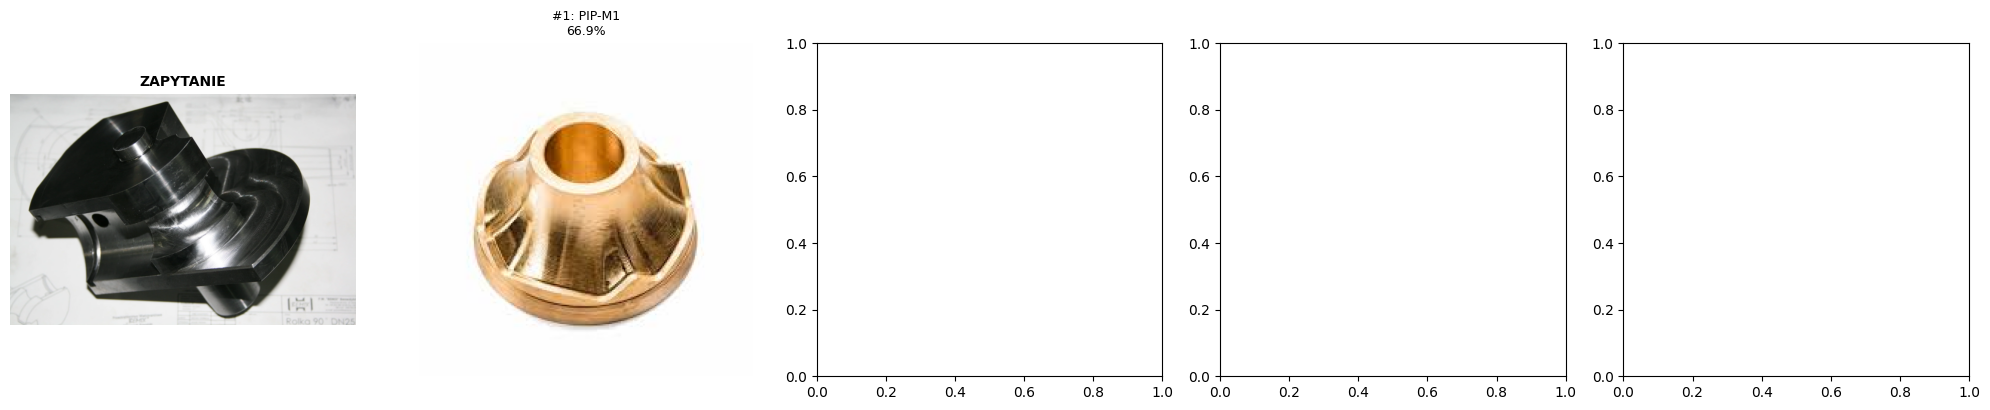


✓ Wyświetlono obraz zapytania i 1 najbardziej podobnych części


In [16]:
# test 6: wizualizacja wyników
print("\n" + "="*70)
print("TEST 6: Wyświetlanie obrazów znalezionych części")
print("="*70)

%pip install -q matplotlib
from PIL import Image
import matplotlib.pyplot as plt

test_image3 = "obrazy/metal/m5.webp"
result6 = rag_search_metal_parts(
    query="Część z obrazu",
    query_type="image",
    image_path=test_image3,
    top_k=4
)

display_search_results(result6)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

if Path(test_image3).exists():
    axes[0].imshow(Image.open(test_image3))
    axes[0].set_title("ZAPYTANIE", fontsize=10, fontweight='bold')
else:
    axes[0].text(0.5, 0.5, "Obraz zapytania\nnie znaleziono", horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)
    axes[0].set_title("ZAPYTANIE", fontsize=10, fontweight='bold')
axes[0].axis('off')

with SessionLocal() as db:
    for idx, (part_dict, score) in enumerate(result6['results'][:4]):
        part_db = db.query(PartDB).filter_by(part_id=part_dict['part_id']).first()
        if part_db and part_db.image_path and Path(part_db.image_path).exists():
            img = Image.open(part_db.image_path)
            axes[idx+1].imshow(img)
            axes[idx+1].set_title(f"#{idx+1}: {part_dict['part_id']}\n{score*100:.1f}%",
                                 fontsize=9)
            axes[idx+1].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Wyświetlono obraz zapytania i {len(result6['results'])} najbardziej podobnych części")

In [17]:
# test 5: wyszukiwanie hybrydowe
print("\n" + "="*70)
print("TEST 5: Wyszukiwanie hybrydowe (tekst + obraz)")
print("="*70)

test_image2 = "obrazy/metal/m3.jpg"
print(f"Wyszukiwanie: tekst + obraz ({test_image2})")

result5 = rag_search_metal_parts(
    query="Łożysko kulkowe do maszyny przemysłowej",
    query_type="hybrid",
    image_path=test_image2,
    top_k=3
)

print(f"\nQuery: {result5['query']}")
print(f"Typ: {result5['query_type']}")
print(f"Obraz zapytania: {test_image2}")
print(f"\nRaport:\n{result5['report']}")


TEST 5: Wyszukiwanie hybrydowe (tekst + obraz)
Wyszukiwanie: tekst + obraz (obrazy/metal/m3.jpg)

Query: Łożysko kulkowe do maszyny przemysłowej
Typ: hybrid
Obraz zapytania: obrazy/metal/m3.jpg

Raport:
RAPORT WYSZUKIWANIA
Zapytanie: Łożysko kulkowe do maszyny przemysłowej
Znaleziono: 1 części


#1 (Dopasowanie: 26.5%)
  ID: PIP-M1
  Opis: Pipe
  Materiał: Tytan
  Kategoria: pipes
  Wymiary: {'source': 'clip_embedding'}
  Tagi: metal, part, pipes, clip_classified, obrazy\metal\m1.jpg




In [18]:
# test 4: wyszukiwanie obrazowe dla wszystkich plików
print("\n" + "="*70)
print("TEST 4: Wyszukiwanie na podstawie obrazu (dla wszystkich obrazów)")
print("="*70)

import glob

image_files = glob.glob("obrazy/metal/*.jpg") + glob.glob("obrazy/metal/*.webp")

if not image_files:
    print("Brak plików obrazów w katalogu 'obrazy/metal'. Upewnij się, że obrazy są przesłane.")
else:
    print(f"\n✓ Znalezione {len(image_files)} plików obrazów\n")
    for idx, test_image in enumerate(image_files, 1):
        print(f"[{idx}/{len(image_files)}] Plik: {test_image}")
        print(f"  Wyszukiwanie podobnych części...")

        result4 = rag_search_metal_parts(
            query="Część metalowa z obrazu",
            query_type="image",
            image_path=test_image,
            top_k=3
        )

        print(f"  ✓ Query: {result4['query']}")
        print(f"  ✓ Typ: {result4['query_type']}")
        print(f"  ✓ Znalezione wyniki: {len(result4['results'])}\n")


TEST 4: Wyszukiwanie na podstawie obrazu (dla wszystkich obrazów)

✓ Znalezione 17 plików obrazów

[1/17] Plik: obrazy/metal\m1.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 1

[2/17] Plik: obrazy/metal\m11.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 1

[3/17] Plik: obrazy/metal\m12.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 1

[4/17] Plik: obrazy/metal\m13.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 1

[5/17] Plik: obrazy/metal\m14.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 1

[6/17] Plik: obrazy/metal\m15.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 1

[7/17] Plik: obrazy/metal\m16.j

## Test 4: Wyszukiwanie na podstawie obrazu

## 10. Statystyki i Podsumowanie

In [19]:
# statystyki bazy
with SessionLocal() as db:
    total_parts = db.query(PartDB).count()
    by_category = {}
    for part in db.query(PartDB).all():
        cat = part.category or "unknown"
        by_category[cat] = by_category.get(cat, 0) + 1

    search_logs = db.query(SearchLog).all()

    print("\n" + "="*70)
    print("STATYSTYKI BAZY DANYCH")
    print("="*70)
    print(f"Łączna liczba części: {total_parts}")
    print(f"\nPodzielenie po kategoriach:")
    for cat, count in by_category.items():
        print(f"  - {cat}: {count}")
    print(f"\nLiczba przeprowadzonych wyszukiwań: {len(search_logs)}")

    if search_logs:
        print(f"\nOstatnie wyszukiwania:")
        for log in search_logs[-5:]:
            print(f"  - {log.query_type}: '{log.query}' → {log.results_count} wyników")


STATYSTYKI BAZY DANYCH
Łączna liczba części: 1

Podzielenie po kategoriach:
  - pipes: 1

Liczba przeprowadzonych wyszukiwań: 22

Ostatnie wyszukiwania:
  - image: 'Część metalowa z obrazu' → 1 wyników
  - image: 'Część metalowa z obrazu' → 1 wyników
  - image: 'Część metalowa z obrazu' → 1 wyników
  - image: 'Część metalowa z obrazu' → 1 wyników
  - image: 'Część metalowa z obrazu' → 1 wyników


In [20]:
# podgląd bazy danych
print("\n" + "="*90)
print("ZAWARTOŚĆ BAZY DANYCH - WSZYSTKIE CZĘŚCI METALOWE")
print("="*90)

with SessionLocal() as db:
    all_parts = db.query(PartDB).all()
    
    if not all_parts:
        print("\n⚠ Baza danych jest pusta")
        print("   Uruchom komórkę 17 aby przetworzyć obrazy\n")
    else:
        print(f"\nLiczba części: {len(all_parts)}\n")
        
        print(f"{'#':<4} | {'Part ID':<15} | {'Nazwa':<25} | {'Kategoria':<12} | {'Materiał':<20} | {'Data':<19}")
        print(f"{'-'*4}-+-{'-'*15}-+-{'-'*25}-+-{'-'*12}-+-{'-'*20}-+-{'-'*19}")
        
        for i, part in enumerate(all_parts, 1):
            part_id = part.part_id[:15]
            name = part.description[:25]
            category = part.category[:12] if part.category else "N/A"
            material = part.material[:20] if part.material else "N/A"
            created = part.created_at[:19] if part.created_at else "N/A"
            
            print(f"{i:<4} | {part_id:<15} | {name:<25} | {category:<12} | {material:<20} | {created:<19}")
        
        print(f"\n{'-'*90}")
        
        by_category = {}
        by_material = {}
        for part in all_parts:
            cat = part.category or "unknown"
            mat = part.material or "unknown"
            by_category[cat] = by_category.get(cat, 0) + 1
            by_material[mat] = by_material.get(mat, 0) + 1
        
        print(f"\n📊 STATYSTYKI:")
        print(f"\nPo kategoriach:")
        for cat, count in sorted(by_category.items(), key=lambda x: x[1], reverse=True):
            print(f"   {cat:.<30} {count:>3}")
        
        print(f"\nPo materiałach:")
        for mat, count in sorted(by_material.items(), key=lambda x: x[1], reverse=True):
            print(f"   {mat:.<30} {count:>3}")
        
        print(f"\n{'-'*90}")
        
        if all_parts:
            print(f"\n📋 PRZYKŁAD - Szczegóły pierwszej części:")
            first = all_parts[0]
            print(f"\n   ID:          {first.part_id}")
            print(f"   Nazwa:       {first.description}")
            print(f"   Kategoria:   {first.category}")
            print(f"   Materiał:    {first.material}")
            print(f"   Wymiary:     {first.dimensions}")
            print(f"   Tagi:        {first.tags}")
            print(f"   Obraz:       {first.image_path}")
            print(f"   Utworzono:   {first.created_at}")
            print(f"\n{'='*90}\n")


ZAWARTOŚĆ BAZY DANYCH - WSZYSTKIE CZĘŚCI METALOWE

Liczba części: 1

#    | Part ID         | Nazwa                     | Kategoria    | Materiał             | Data               
-----+-----------------+---------------------------+--------------+----------------------+--------------------
1    | PIP-M1          | Pipe                      | pipes        | Tytan                | 2026-01-09T14:23:25

------------------------------------------------------------------------------------------

📊 STATYSTYKI:

Po kategoriach:
   pipes.........................   1

Po materiałach:
   Tytan.........................   1

------------------------------------------------------------------------------------------

📋 PRZYKŁAD - Szczegóły pierwszej części:

   ID:          PIP-M1
   Nazwa:       Pipe
   Kategoria:   pipes
   Materiał:    Tytan
   Wymiary:     {'source': 'clip_embedding'}
   Tagi:        ['metal', 'part', 'pipes', 'clip_classified', 'obrazy\\metal\\m1.jpg']
   Obraz:       obrazy\me

In [21]:
# diagnostyka wyszukiwań obrazowych
print("\n" + "="*70)
print("DIAGNOSTYKA: Analiza wyszukiwań obrazowych")
print("="*70)

with SessionLocal() as db:
    image_searches = db.query(SearchLog).filter_by(query_type="image").all()
    print(f"\nLiczba wyszukiwań obrazowych: {len(image_searches)}")
    
    if image_searches:
        print(f"\nLista wszystkich image searches:")
        for i, log in enumerate(image_searches, 1):
            print(f"  {i}. Query: '{log.query}' | Timestamp: {log.timestamp} | Wyniki: {log.results_count}")
    
    text_searches = db.query(SearchLog).filter_by(query_type="text").count()
    hybrid_searches = db.query(SearchLog).filter_by(query_type="hybrid").count()
    
    print(f"\nPodsumowanie:")
    print(f"  - Tekst (text): {text_searches}")
    print(f"  - Obraz (image): {len(image_searches)}")
    print(f"  - Hybrydowe (hybrid): {hybrid_searches}")
    print(f"  - RAZEM: {text_searches + len(image_searches) + hybrid_searches}")


DIAGNOSTYKA: Analiza wyszukiwań obrazowych

Liczba wyszukiwań obrazowych: 18

Lista wszystkich image searches:
  1. Query: 'Część z obrazu' | Timestamp: 2026-01-09T14:24:23.967572 | Wyniki: 1
  2. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-09T14:24:27.365422 | Wyniki: 1
  3. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-09T14:24:28.577083 | Wyniki: 1
  4. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-09T14:24:29.815588 | Wyniki: 1
  5. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-09T14:24:31.018758 | Wyniki: 1
  6. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-09T14:24:32.336112 | Wyniki: 1
  7. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-09T14:24:33.570100 | Wyniki: 1
  8. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-09T14:24:34.763736 | Wyniki: 1
  9. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-09T14:24:36.079361 | Wyniki: 1
  10. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-09T14:24:37.391923 | Wyniki

In [22]:
# przetwórz wszystkie obrazy i zapisz do bazy

print("\n" + "="*80)
print("PRZYGOTOWANIE: CZYSZCZENIE BAZY DANYCH")
print("="*80)

with SessionLocal() as db:
    deleted_parts = db.query(PartDB).count()
    deleted_logs = db.query(SearchLog).count()
    
    db.query(PartDB).delete()
    db.query(SearchLog).delete()
    db.commit()
    
    print(f"✓ Usunięto {deleted_parts} części")
    print(f"✓ Usunięto {deleted_logs} logów wyszukiwań")
    print(f"✓ Baza danych wyczyszczona i gotowa do użycia")

print("\n" + "="*80)
print("PRZETWARZANIE: WSZYSTKIE OBRAZY Z FOLDERU 'obrazy/metal/'")
print("="*80)

from pathlib import Path
image_folder = Path("obrazy/metal/")
image_extensions = ['.jpg', '.jpeg', '.png', '.webp', '.bmp']
all_images = []

for ext in image_extensions:
    all_images.extend(image_folder.glob(f"*{ext}"))
    all_images.extend(image_folder.glob(f"*{ext.upper()}"))

all_images = sorted(list(set(all_images)))

print(f"\n📂 Znaleziono {len(all_images)} obrazów do przetworzenia")
print(f"📡 Metoda rozpoznawania: {'OpenAI API' if OPENAI_API_KEY else 'CLIP Embedding (lokalnie)'}\n")

if not all_images:
    print("⚠ Brak obrazów w folderze obrazy/metal/")
    print("   Upewnij się że obrazy są w folderze i uruchom ponownie.")
else:
    processed_parts = []
    
    for i, image_path in enumerate(all_images, 1):
        print(f"\n[{i}/{len(all_images)}] {'='*60}")
        print(f"📷 Plik: {image_path.name}")
        print(f"{'='*70}")
        
        try:
            part = classify_metal_part_from_image(str(image_path))
            
            if part:
                processed_parts.append(part)
                print(f"\n✓ ROZPOZNANO:")
                print(f"   Part ID:    {part.part_id}")
                print(f"   Nazwa:      {part.description}")
                print(f"   Kategoria:  {part.category}")
                print(f"   Materiał:   {part.material}")
            else:
                print(f"\n✗ Nie udało się rozpoznać")
                
        except Exception as e:
            print(f"\n✗ Błąd: {e}")
    
    print(f"\n{'='*80}")
    print(f"ZAPISYWANIE DO BAZY DANYCH: {len(processed_parts)} CZĘŚCI")
    print(f"{'='*80}\n")
    
    with SessionLocal() as db:
        success_count = 0
        for part in processed_parts:
            if add_part_to_db(db, part):
                success_count += 1
                print(f"✓ {part.part_id}: {part.description}")
                print(f"  └─ {part.category} | {part.material}")
        
        print(f"\n{'='*80}")
        print(f"✓✓✓ ZAKOŃCZONO POMYŚLNIE ✓✓✓")
        print(f"{'='*80}")
        print(f"Zapisano:        {success_count}/{len(processed_parts)} części")
        print(f"Baza danych:     metal_parts.db")
        print(f"Tabela:          metal_parts")
        print(f"{'='*80}\n")
        
        print("📋 Przykładowe rekordy w bazie:\n")
        sample_parts = db.query(PartDB).limit(3).all()
        for p in sample_parts:
            print(f"   • {p.part_id}: {p.description} ({p.category}, {p.material})")


PRZYGOTOWANIE: CZYSZCZENIE BAZY DANYCH
✓ Usunięto 1 części
✓ Usunięto 22 logów wyszukiwań
✓ Baza danych wyczyszczona i gotowa do użycia

PRZETWARZANIE: WSZYSTKIE OBRAZY Z FOLDERU 'obrazy/metal/'

📂 Znaleziono 17 obrazów do przetworzenia
📡 Metoda rozpoznawania: CLIP Embedding (lokalnie)


[1/17] ============================================================
📷 Plik: m1.jpg
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Pipe (pipes)

✓ ROZPOZNANO:
   Part ID:    PIP-M1
   Nazwa:      Pipe
   Kategoria:  pipes
   Materiał:   Tytan

[2/17] ============================================================
📷 Plik: m10.webp
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Fastener (fasteners)

✓ ROZPOZNANO:
   Part ID:    FAS-M10
   Nazwa:      Fastener
   Kategoria:  fasteners
   Materiał:   Aluminium

[3/17] 

In [ ]:
# === FRONTEND: Dodawanie nowych części metalowych ===
# Uruchom tę komórkę, aby wyświetlić interfejs do przesyłania zdjęć

%pip install ipywidgets

from pathlib import Path
from datetime import datetime
import os, io, base64
from PIL import Image
import ipywidgets as W
from IPython.display import display, HTML, clear_output

# Docelowy folder na obrazy
project_root = Path.cwd()
metal_dir = project_root / 'obrazy' / 'metal'
metal_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Folder docelowy: {metal_dir}")
print(f"📊 Baza danych: metal_parts.db")
print()

# ===== Widgety =====
# Pole na nazwę/podpis zdjęcia
txt_name = W.Text(
    placeholder='Wpisz nazwę zdjęcia (np. "śruba M8", "łożysko 6205")',
    description='Nazwa:',
    layout=W.Layout(width='400px')
)

# Upload pliku
file_upload = W.FileUpload(
    accept='.png,.jpg,.jpeg,.webp,.bmp',
    multiple=False,
    description='Wybierz zdjęcie'
)

# Przycisk zapisu
btn_save = W.Button(
    description='📥 Zapisz i klasyfikuj',
    button_style='success',
    icon='check',
    layout=W.Layout(width='200px')
)

# Obszar na komunikaty
output = W.Output()

# ===== Funkcje pomocnicze =====
def sanitize_filename(text: str) -> str:
    """Usuń niedozwolone znaki z nazwy pliku."""
    safe = ''.join(c for c in text if c.isalnum() or c in ('-', '_', ' ', '.')).strip()
    return safe.replace(' ', '_') or 'bez_nazwy'


def save_uploaded_image(raw_bytes: bytes, ext: str, name: str) -> Path:
    """Zapisz obraz do folderu metal z nazwą z formularza."""
    base = sanitize_filename(name)
    base_without_ext, provided_ext = os.path.splitext(base)
    final_ext = (provided_ext or ext).lower() or '.png'
    stem = base_without_ext or 'bez_nazwy'

    candidate = metal_dir / f"{stem}{final_ext}"
    counter = 1
    while candidate.exists():
        candidate = metal_dir / f"{stem}_{counter}{final_ext}"
        counter += 1

    Image.open(io.BytesIO(raw_bytes)).save(candidate)
    return candidate


def find_similar_parts_for_image(image_path: str, top_k: int = 5, category_hint: Optional[str] = None):
    """Znajdź podobne części z bazy na podstawie embeddingu obrazu."""
    if not Path(image_path).exists():
        return []

    with SessionLocal() as db:
        results = search_parts_by_image(
            db,
            image_path=image_path,
            top_k=top_k,
            category_filter=category_hint
        )

        ranked = []
        for idx, (part, score) in enumerate(results, 1):
            ranked.append({
                "rank": idx,
                "part_id": part.part_id,
                "description": part.description,
                "material": part.material,
                "category": part.category,
                "image_path": part.image_path,
                "score": float(score),
            })

    return ranked


# ===== Handler przycisku =====
def on_save_click(_):
    output.clear_output()
    
    with output:
        # 1. Walidacja: nazwa
        name = txt_name.value.strip()
        if not name:
            print('⚠️ Proszę wpisać nazwę zdjęcia!')
            return
        
        # 2. Walidacja: plik
        if not file_upload.value:
            print('⚠️ Proszę wybrać zdjęcie do przesłania!')
            return
        
        try:
            # 3. Pobierz dane z uploadu
            val = file_upload.value
            
            # Normalizacja formatu (różne wersje ipywidgets)
            if isinstance(val, dict):
                entries = list(val.values())
            elif isinstance(val, (list, tuple)):
                entries = list(val)
            else:
                entries = [val]
            
            if len(entries) != 1:
                print(f'⚠️ Prześlij dokładnie 1 zdjęcie (wybrano: {len(entries)})')
                return
            
            uploaded = entries[0]
            
            # Wydobądź bajty i nazwę pliku
            raw = None
            filename = None
            
            if isinstance(uploaded, dict):
                raw = uploaded.get('content')
                filename = uploaded.get('name') or (uploaded.get('metadata') or {}).get('name')
                
                # Szukaj bajtów w innych polach
                if raw is None:
                    for v in uploaded.values():
                        if isinstance(v, (bytes, bytearray, memoryview)):
                            raw = v
                            break
            
            # Konwertuj memoryview na bytes
            if isinstance(raw, memoryview):
                raw = bytes(raw)
            
            if not isinstance(raw, (bytes, bytearray)):
                print('❌ Nie udało się odczytać pliku. Spróbuj ponownie.')
                print(f'   Debug: typ={type(uploaded)}, klucze={uploaded.keys() if isinstance(uploaded, dict) else "N/A"}')
                return
            
            # 4. Zapisz obraz do folderu metal
            ext = os.path.splitext(filename or name)[1].lower() or '.png'
            saved_path = save_uploaded_image(raw, ext, name)
            
            print(f'✅ Zapisano: {saved_path.name}')
            print(f'📂 Lokalizacja: obrazy/metal/{saved_path.name}')
            print()
            print('='*60)
            print('🔍 KLASYFIKACJA OBRAZU')
            print('='*60)
            
            # 5. Klasyfikuj obraz
            part = classify_metal_part_from_image(str(saved_path))
            
            if part:
                print()
                print('✅ Rozpoznano część:')
                print(f'   📋 Part ID:   {part.part_id}')
                print(f'   📝 Nazwa:     {part.description}')
                print(f'   📁 Kategoria: {part.category}')
                print(f'   🔧 Materiał:  {part.material}')
                print()
                
                # 6. Ranking podobnych części w bazie
                similar = find_similar_parts_for_image(str(saved_path), top_k=5, category_hint=part.category)
                if similar:
                    print('📊 Ranking podobnych (1-5):')
                    for row in similar:
                        print(f"  #{row['rank']}: {row['description']} [{row['part_id']}] ({row['category']}, {row['material']}) | score: {row['score']:.4f}")
                        if row.get('image_path'):
                            print(f"     Obraz: {row['image_path']}")
                    print()
                else:
                    print('📊 Brak podobnych części w bazie (brak embeddingów lub pusta baza).\n')
                
                # 7. Dodaj do bazy danych
                print('💾 Zapisywanie do bazy danych...')
                with SessionLocal() as db:
                    existing = db.query(PartDB).filter_by(image_path=str(saved_path)).first()
                    if existing:
                        print(f'⚠️ Obraz już istnieje w bazie jako: {existing.part_id}')
                    else:
                        success = add_part_to_db(db, part)
                        if success:
                            total = db.query(PartDB).count()
                            print()
                            print('='*60)
                            print('✅ GOTOWE!')
                            print('='*60)
                            print(f'📊 Baza zawiera teraz: {total} części')
                            print(f'📁 Plik: {saved_path.name}')
                            print(f'🆔 Part ID: {part.part_id}')
                            print('='*60)
                        else:
                            print('❌ Błąd podczas zapisywania do bazy')
            else:
                print()
                print('❌ Nie udało się rozpoznać obrazu')
                print(f'   Plik został zapisany w: {saved_path}')
            
            # 8. Wyczyść formularz
            txt_name.value = ''
            try:
                file_upload.value = ()
            except:
                try:
                    file_upload.value = []
                except:
                    pass
                    
        except Exception as e:
            print(f'❌ Błąd: {e}')
            import traceback
            traceback.print_exc()

btn_save.on_click(on_save_click)

# ===== Wyświetl UI =====
ui = W.VBox([
    W.HTML('<h3>📷 Dodaj nową część metalową</h3>'),
    W.HTML('<p>Wpisz nazwę zdjęcia, wybierz plik i kliknij przycisk.</p>'),
    txt_name,
    file_upload,
    btn_save,
    W.HTML('<hr>'),
    output
])

display(ui)


Note: you may need to restart the kernel to use updated packages.
📁 Folder docelowy: c:\Users\hubert.pazdzioch\Desktop\Vision_RAG\Vision_Picture_RAG\Vision_Picture_RAG\obrazy\metal
📊 Baza danych: metal_parts.db

